In [1]:
import os
import numpy as np
import pandas as pd
# import json
# from pandas.io.json import json_normalize
# from ast import literal_eval
import random
import time
import matplotlib.pyplot as plt

In [20]:
def feature_encode(df):
    categorical = ['channelGrouping',
                 'device.deviceCategory',
                 'device.operatingSystem',
                 'geoNetwork.continent',
                 'geoNetwork.country',
                 'geoNetwork.region',
                 'trafficSource.adContent',
                 'trafficSource.adwordsClickInfo.adNetworkType',
                 'trafficSource.adwordsClickInfo.slot',
                 'trafficSource.campaign',
                 'trafficSource.keyword',
                 'trafficSource.source',
                 'contentGroup.contentGroup2',
                 'contentGroup.contentGroup3',
                 'eventInfo.eventAction',
                 'Year',
                 'Month',
                 'Day',
                 'is_holiday',
                 'device_browser',
                 'is_inbasket',
                 'is_discountad']
    numeric = ['visitNumber',
             'totals.bounces',
             'totals.hits',
             'totals.newVisits',
             'totals.pageviews',
             'totals.sessionQualityDim',
             'totals.timeOnSite',
             'totals.transactions',
             'trafficSource.adwordsClickInfo.page']
    
    floatcol = ['totals.totalTransactionRevenue',
             'totals.transactionRevenue']
    
    for each in categorical:
        df[each] = df[each].astype('category')
    
    for each in categorical:
        df[each] = df[each].cat.codes
    
    for each in numeric:
        df[each] = df[each].astype('float32')
    
    for each in floatcol:
        df[each] = df[each].astype('float')
    
    return df

In [2]:
train_df = pd.read_csv('Data/train_df.csv')
train_df.head()

C:\Users\samarth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,channelGrouping,fullVisitorId,visitNumber,device.deviceCategory,device.operatingSystem,geoNetwork.continent,geoNetwork.country,geoNetwork.region,totals.bounces,totals.hits,...,contentGroup.contentGroup2,contentGroup.contentGroup3,eventInfo.eventAction,Year,Month,Day,is_holiday,device_browser,is_inbasket,is_discountad
0,Organic Search,3162355547410993243,1.0,desktop,Windows,Europe,Germany,NaN,1.0,1.0,...,Bags,NaN,NaN,2017,10,16,0,Firefox,0,0
1,Referral,8934116514970143966,6.0,desktop,Chrome OS,Americas,United States,California,0.0,2.0,...,NaN,NaN,NaN,2017,10,16,0,Chrome,0,0
2,Direct,7992466427990357681,1.0,mobile,Android,Americas,United States,NaN,0.0,2.0,...,NaN,NaN,NaN,2017,10,16,0,Chrome,0,0
3,Organic Search,9075655783635761930,1.0,desktop,Windows,Asia,Turkey,NaN,0.0,2.0,...,NaN,NaN,NaN,2017,10,16,0,Chrome,0,0
4,Organic Search,6960673291025684308,1.0,desktop,Windows,Americas,Mexico,NaN,0.0,2.0,...,NaN,NaN,NaN,2017,10,16,0,Chrome,0,0


In [21]:
train_df = feature_encode(train_df)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099989 entries, 0 to 1099988
Data columns (total 34 columns):
channelGrouping                                 1099989 non-null int8
fullVisitorId                                   1099989 non-null object
visitNumber                                     1099989 non-null float32
device.deviceCategory                           1099989 non-null int8
device.operatingSystem                          1099989 non-null int8
geoNetwork.continent                            1099989 non-null int8
geoNetwork.country                              1099989 non-null int16
geoNetwork.region                               1099989 non-null int16
totals.bounces                                  1099989 non-null float32
totals.hits                                     1099989 non-null float32
totals.newVisits                                1099989 non-null float32
totals.pageviews                                1099831 non-null float32
totals.sessionQualityDim    

In [23]:
val_df = pd.read_csv('Data/val_df.csv')
val_df = feature_encode(val_df)

C:\Users\samarth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
test_df = pd.read_csv('Data/test_df.csv')
test_df = feature_encode(test_df)

C:\Users\samarth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
y_train = np.log1p(train_df["totals.transactionRevenue"].values)
X_train = train_df.drop(['fullVisitorId', 'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'totals.transactions'], axis =1)

In [26]:
y_val = np.log1p(val_df["totals.transactionRevenue"].values)
X_val = val_df.drop(['fullVisitorId', 'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'totals.transactions'], axis =1)

In [27]:
y_test = np.log1p(test_df["totals.transactionRevenue"].values)
X_test = test_df.drop(['fullVisitorId', 'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'totals.transactions'], axis =1)

In [28]:
test_id = test_df["fullVisitorId"].values

### LGBM

In [11]:
import lightgbm as lgb

In [14]:
# custom function to run light gbm model

def run_lgb(X_train, y_train, X_val, y_val, X_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(X_test, num_iteration=model.best_iteration)
    pred_val_y = model.predict(X_val, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

#Training the model 

pred_test, model, pred_val = run_lgb(X_train, y_train, X_val, y_val, X_test)


C:\Users\samarth\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.48609
[200]	valid_0's rmse: 1.48531
[300]	valid_0's rmse: 1.48423
Early stopping, best iteration is:
[283]	valid_0's rmse: 1.48379


In [15]:
#Validation score

from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.5224778875337688


In [18]:
# Predicting on test dataset

sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

In [19]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,3038793126460,0.000000
1,13360843297579,0.008963
2,25784765293776,0.000000
3,47810105303746,0.000000
4,52246474382344,0.000748


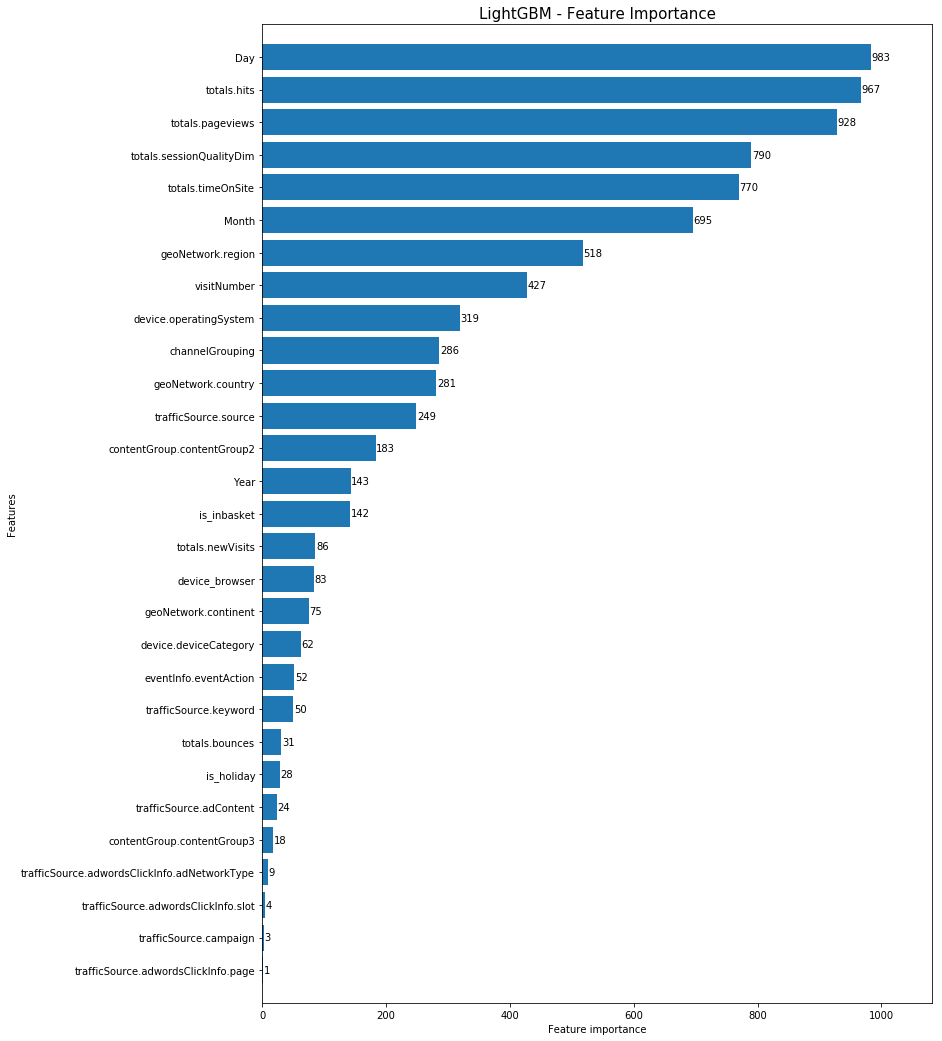

In [20]:
# Important features of lgbm

fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### xgboost

In [40]:
def rmse(y_true, y_pred):
    return round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 5)

In [41]:
import xgboost as xgb

In [42]:
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [43]:
xgb_preds, xgb_model = run_xgb(X_train, y_train, X_val, y_val, X_test)

[0]	train-rmse:1.86358	valid-rmse:1.89084
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.6441	valid-rmse:1.74728
[1000]	train-rmse:1.52983	valid-rmse:1.67604
[1500]	train-rmse:1.46325	valid-rmse:1.63704
[1999]	train-rmse:1.42257	valid-rmse:1.61346
XGB : RMSE val: 1.61347  - RMSE train: 1.42257


### CatBoost

In [29]:
from catboost import CatBoostRegressor

In [38]:
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [39]:
cat_preds, cat_model = run_catboost(X_train, y_train, X_val, y_val,  X_test)

0:	learn: 1.8197827	test: 1.8701920	best: 1.8701920 (0)	total: 664ms	remaining: 11m 3s
50:	learn: 1.4870562	test: 1.6703879	best: 1.6703879 (50)	total: 35.1s	remaining: 10m 52s
100:	learn: 1.4578518	test: 1.6339805	best: 1.6339805 (100)	total: 1m 9s	remaining: 10m 16s
150:	learn: 1.4388722	test: 1.6231949	best: 1.6231949 (150)	total: 1m 43s	remaining: 9m 39s
200:	learn: 1.4225466	test: 1.6178963	best: 1.6178963 (200)	total: 2m 16s	remaining: 9m 3s
250:	learn: 1.4086797	test: 1.6132063	best: 1.6132063 (250)	total: 2m 54s	remaining: 8m 40s
300:	learn: 1.3954613	test: 1.6094443	best: 1.6094443 (300)	total: 3m 31s	remaining: 8m 11s
350:	learn: 1.3839433	test: 1.6078759	best: 1.6078759 (350)	total: 4m 5s	remaining: 7m 34s
400:	learn: 1.3734645	test: 1.6058283	best: 1.6057459 (399)	total: 4m 40s	remaining: 6m 59s
450:	learn: 1.3628215	test: 1.6034163	best: 1.6034163 (450)	total: 5m 15s	remaining: 6m 23s
500:	learn: 1.3522289	test: 1.6023305	best: 1.6023086 (499)	total: 5m 50s	remaining: 5m 4

In [36]:
from sklearn import metrics